In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
import ast

dict_columns = ['Validation_Base_SimulationRes']

def flatten_columns(result_df, dict_columns):
    for col in dict_columns:
        # Convert string to dict only if needed
        result_df[col] = result_df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
        
        # Expand the dictionary into separate columns
        expanded = result_df[col].apply(pd.Series).add_prefix(f"{col}_")
        
        # Merge into original dataframe
        result_df = result_df.drop(columns=[col]).join(expanded)
    return result_df

In [3]:
test_data = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V5-short.xlsx', index_col=0)
test_data.reset_index(drop=True, inplace=True)

In [4]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [27]:
cases_list = [           
             {'CaseName': 'No Replay', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-noreplay.xlsx'},
              {'CaseName': 'Replay 0.5%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-replay-0.005.xlsx'},
              {'CaseName': 'Replay 1%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one.xlsx'},
              {'CaseName': 'Replay 2.5%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-replay-0.025.xlsx'},
              {'CaseName': 'Replay 5%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-replay-0.05.xlsx'},
              {'CaseName': 'Replay 10%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-replay-0.1.xlsx'},
              {'CaseName': 'Replay 25%', 'Type':'FNN-low', 'resultfile': '../05_Workflow_LHS_small/Results/OnlineLearning/Calibration_result_online_always-one-replay-0.25.xlsx'},
              


              

              
              ]

In [37]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        cost_data.append({
                    'Case': case['CaseName'],
                    'Calibration cost': np.round(df['Validation_Base_SimCost'].mean(), 4),
                    'Direct calibration': df['Calibration_Direct_SimCost'].notna().sum(),
                    'Local improvement': np.round(df['LocalImprovement'].mean(),1),
                    'Global retention': np.round(df['GlobalRetention'].mean(),1),
                    #'Calibration time': df[['Calibration_Base_EllapsedTime', 'Calibration_Direct_EllapsedTime']].sum(axis=1).mean()
                    
                    
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)


cost_df

,Case,Calibration cost,Direct calibration,Local improvement,Global retention
0,No Replay,0.0475,70,30.1,0.6
1,Replay 0.5%,0.0275,38,17.0,1.5
2,Replay 1%,0.0267,32,12.9,1.8
3,Replay 2.5%,0.0271,34,21.4,2.2
4,Replay 5%,0.0371,57,14.7,2.6
5,Replay 10%,0.0590,93,10.3,2.9
6,Replay 25%,0.0713,112,2.3,3.2


C:\Users\pales\AppData\Local\Temp\ipykernel_32036\278551417.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


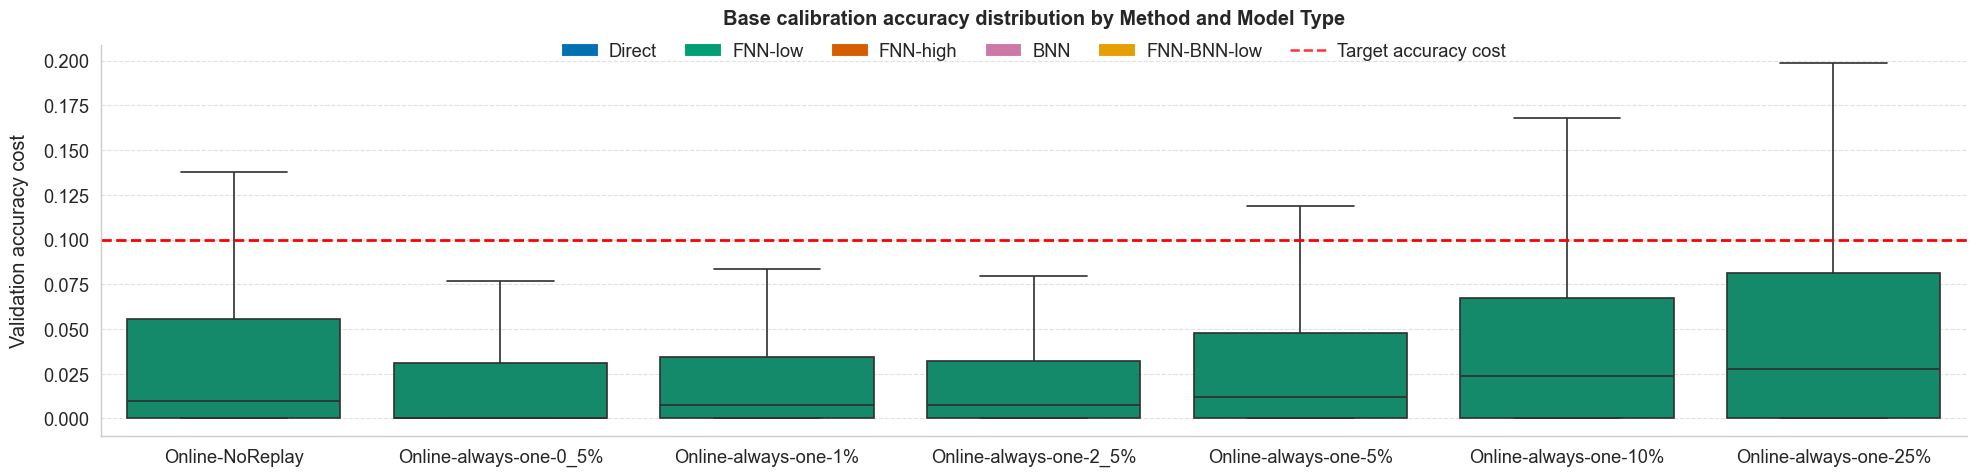

In [24]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['CaseName'] not in ['No-Calibration']:
            for cost in df['Validation_Base_SimCost']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'Calibration Cost': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)


# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
}

# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='Calibration Cost',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)

# Add horizontal line for target validation accuracy cost
target_cost = 0.1  # <-- Set your target value here
ax.axhline(target_cost, color='red', linestyle='--', linewidth=2)

# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Target accuracy cost')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Titles and labels
ax.set_title('Base calibration accuracy distribution by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Validation accuracy cost', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

C:\Users\pales\AppData\Local\Temp\ipykernel_32036\3566648416.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


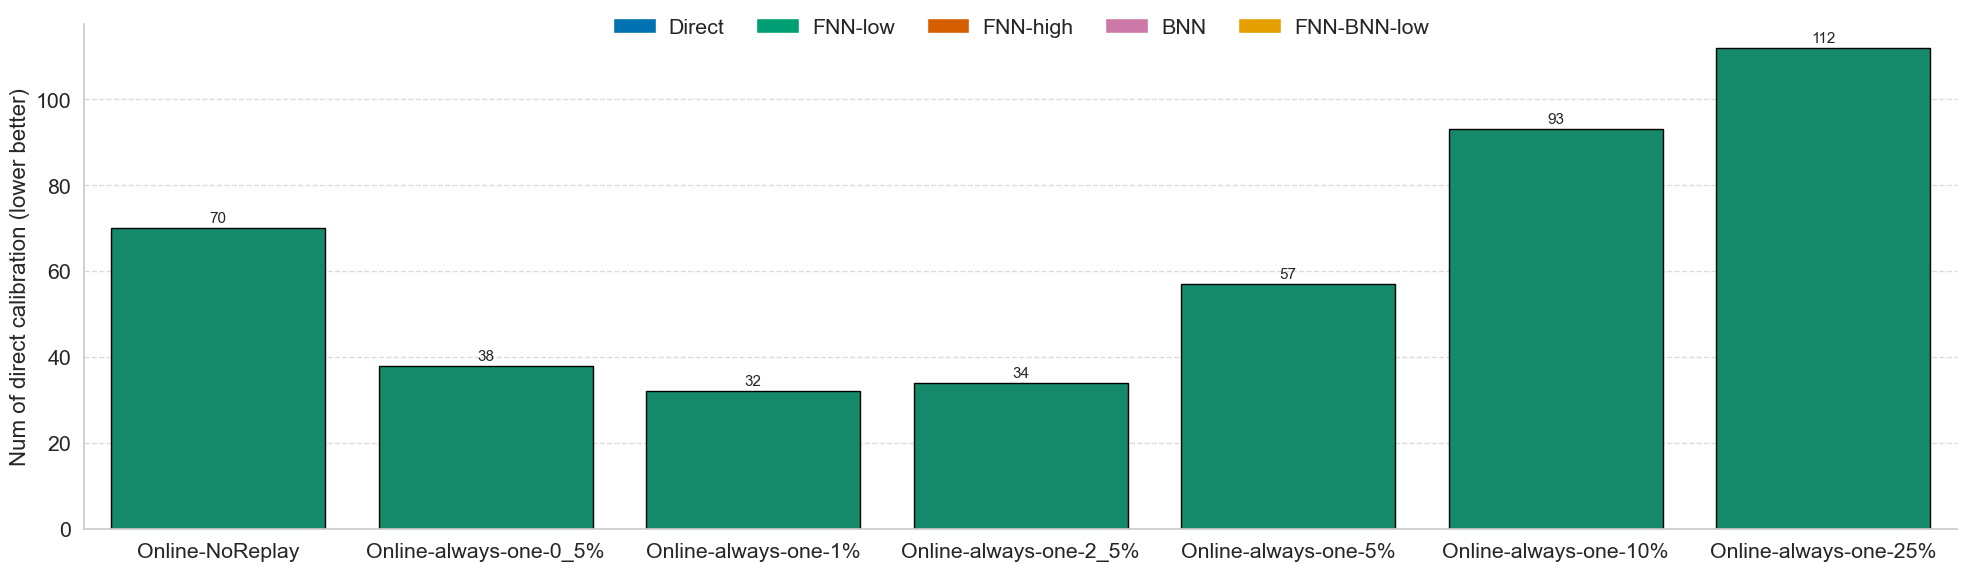

In [15]:
# Collect all costs into a single DataFrame
cost_data = []
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)
        if case['CaseName'] == 'Surrogate' and case['Type'] == 'BNN':
            add_direct_calibration_cost(df, direct_calibration_df)
        if case['Type'] == 'direct':
            count = len(df['Calibration_Direct_SimCost'])
        else:
            count = df['Calibration_Direct_SimCost'].notna().sum()
        cost_data.append({
            'Case': case['CaseName'],
            'Model type': case['Type'],
            'Direct calibration': count
        })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Set style and font
sns.set_theme(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(20, 6))

# Use colorblind-friendly palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}

# Draw barplot
ax = sns.barplot(
    data=cost_df,
    x='Case',
    y='Direct calibration',
    hue='Model type',
    palette=model_type_palette,
    edgecolor='black'
)

# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=2, fontsize=11)


# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['BNN'], label='BNN'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)


# Titles and labels
#ax.set_title('Num of direct calibration by method and model type', fontsize=18, pad=15)
ax.set_ylabel('Num of direct calibration (lower better)', fontsize=16)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Remove top/right spines and add gridlines
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

C:\Users\pales\AppData\Local\Temp\ipykernel_32036\1556434965.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


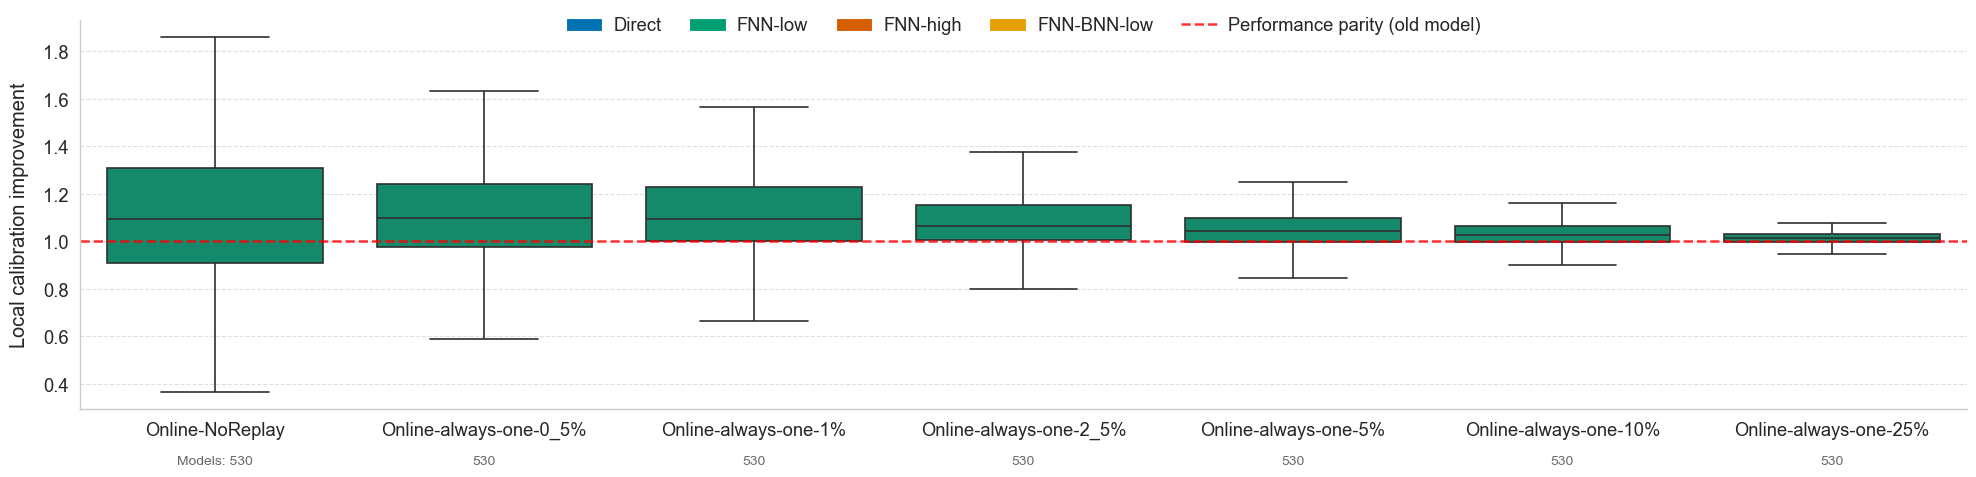

In [16]:
# Collect all costs into a single DataFrame
cost_data = []
model_versions = {}  # Store model_version_num for each (Case, Model type)
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)

        if case['CaseName'].startswith("Online"):
            model_version_num = len(df['New_Surrogate_version'].unique())
            model_versions[(case['CaseName'], case['Type'])] = model_version_num
            for cost in df['LocalImprovement']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'LocalImprovement': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}

# Explicit order
cases = sorted(cost_df['Case'].unique(), key=list(cost_df['Case'].unique()).index)
model_types = sorted(cost_df['Model type'].unique(), key=list(cost_df['Model type'].unique()).index)


# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='LocalImprovement',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)

# Horizontal "ideal" line
target_cost = 1
ax.axhline(target_cost, color='red', linestyle='--', linewidth=1.8, alpha=0.8)

# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Performance parity (old model)')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Place model counts below each group
n_hue = len(model_types)
bias = 0.03 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # small vertical offset
ii = 0
for i_case, case in enumerate(cases):
    for i_hue, model_type in enumerate(model_types):
        key = (case, model_type)
        if key in model_versions:
            x = i_case - 0.4 + (i_hue + 0.5) * 0.8 / n_hue
            if ii == 0:
                titlet = 'Models: '
            else:
                titlet = ''
            ax.text(
                x, 0 + bias,
                f"{titlet}{model_versions[key]}", ha='center', va='bottom', fontsize=10, color='dimgray'
            )
            ii += 1

# Titles and labels
#ax.set_title('Local calibration improvement by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Local calibration improvement', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

C:\Users\pales\AppData\Local\Temp\ipykernel_32036\3586821588.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')


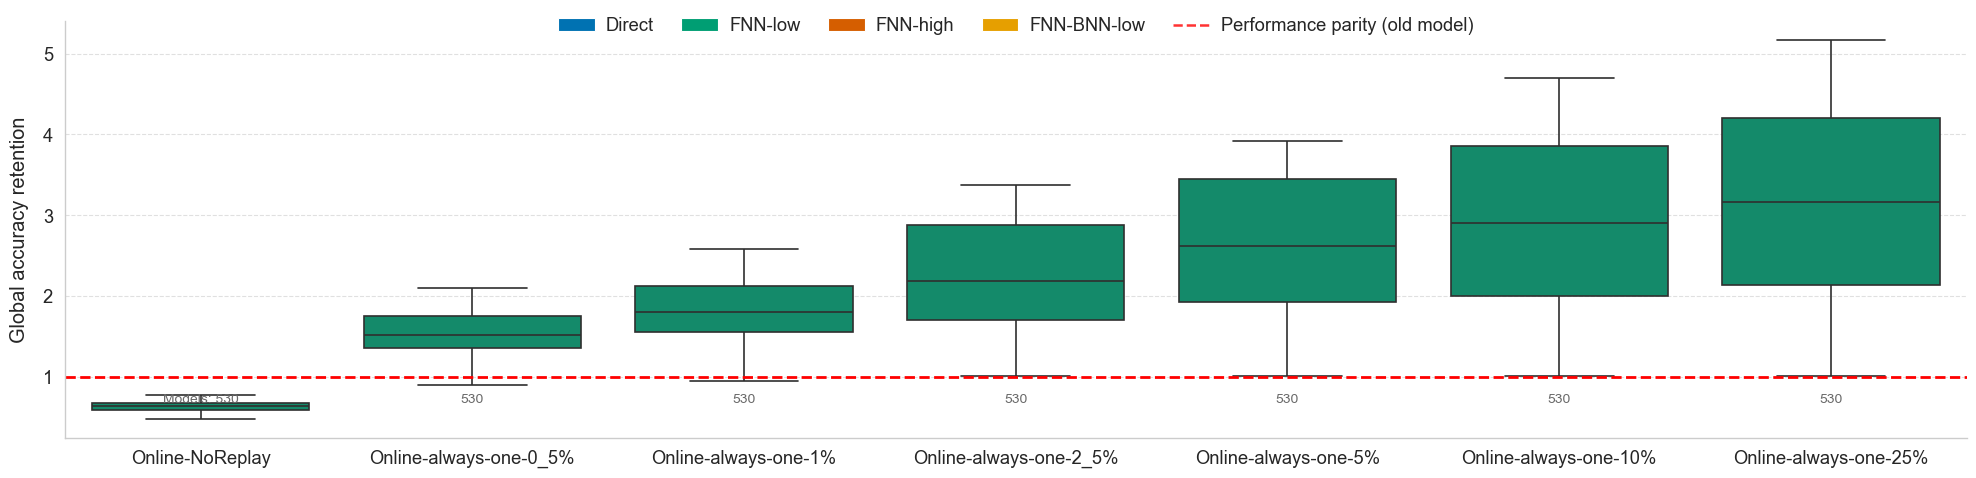

In [17]:
# Collect all costs into a single DataFrame
cost_data = []
model_versions = {}  # Store model_version_num for each (Case, Model type)
for case in cases_list:
    try:
        df = pd.read_excel(case['resultfile'], index_col=0)

        if case['CaseName'].startswith("Online"):
            model_version_num = len(df['New_Surrogate_version'].unique())
            model_versions[(case['CaseName'], case['Type'])] = model_version_num
            for cost in df['GlobalRetention']:
                cost_data.append({
                    'Case': case['CaseName'],
                    'Model type': case['Type'],
                    'GlobalRetention': cost
                })
    except Exception as e:
        print(f"Could not load {case['resultfile']}: {e}")

cost_df = pd.DataFrame(cost_data)

# Modern style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 5))
sns.set_context("paper", font_scale=1.5)  # good for scientific figures

# Color palette
model_type_palette = {
    'direct': '#0072B2',         # blue
    'FNN-low': '#009E73',  # green
    'FNN-high': '#D55E00',  # orange/red
    'BNN': '#CC79A7',
    'FNN-BNN-low': '#E69F00',
    'nocalibration' : '#999999',
}
# Explicit order
cases = sorted(cost_df['Case'].unique(), key=list(cost_df['Case'].unique()).index)
model_types = sorted(cost_df['Model type'].unique(), key=list(cost_df['Model type'].unique()).index)

# Boxplot
ax = sns.boxplot(
    data=cost_df,
    x='Case',
    y='GlobalRetention',
    hue='Model type',
    palette=model_type_palette,
    showfliers=False,
    linewidth=1.2
)


# Add horizontal line for target validation accuracy cost
target_cost = 1  # <-- Set your target value here
ax.axhline(target_cost, color='red', linestyle='--', linewidth=2)
# Custom legend: "Model type" inline
handles = [
    #Patch(facecolor='none', edgecolor='none', label='Model type:'),
    Patch(facecolor=model_type_palette['direct'], label='Direct'),
    Patch(facecolor=model_type_palette['FNN-low'], label='FNN-low'),
    Patch(facecolor=model_type_palette['FNN-high'], label='FNN-high'),
    Patch(facecolor=model_type_palette['FNN-BNN-low'], label='FNN-BNN-low'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.8, alpha=0.8, label='Performance parity (old model)')
]
ax.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(handles),
    frameon=False,
    handletextpad=0.6,
    columnspacing=1.5
)

# Place model counts below each group
n_hue = len(model_types)
bias = 0.125 * (ax.get_ylim()[1] - ax.get_ylim()[0])  # small vertical offset
ii = 0
for i_case, case in enumerate(cases):
    for i_hue, model_type in enumerate(model_types):
        key = (case, model_type)
        if key in model_versions:
            x = i_case - 0.4 + (i_hue + 0.5) * 0.8 / n_hue
            if ii == 0:
                titlet = 'Models: '
            else:
                titlet = ''
            ax.text(
                x, 0 + bias,
                f"{titlet}{model_versions[key]}", ha='center', va='bottom', fontsize=10, color='dimgray'
            )
            ii += 1

# Titles and labels
#ax.set_title('Global accuracy retention by Method and Model Type', pad=15, weight='bold')
ax.set_ylabel('Global accuracy retention', labelpad=10)
ax.set_xlabel('')

# X-tick rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# Clean up style
sns.despine()
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()